In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_indicators, from_contents
from upsetplot import plot as upset
import matplotlib
import muon

fsize=15

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax, plot_line=False):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  c="white"
  if plot_line:
    c="k"
  ax.plot(lims, lims, c, alpha=0.75, zorder=0)
  ax.set(**{
      "aspect": "equal",
      "xlim": lims,
      "ylim": lims
  })
  return ax

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [40]:
blue = "#34CBBF"
red = "#CB3440"

In [41]:
ss = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/shareseqv2/hgmm/mu.h5mu")
sa = muon.read_h5mu("/home/sina/projects/atac/scATAK/data/issaacseq/hgmm/mu.h5mu")

genes_hg = sa.var[sa.var.index.str.contains("ENSG")].index
genes_mm = sa.var[sa.var.index.str.contains("ENSMUS")].index

In [42]:
ss_hg = ss.var["counts_sum"][genes_hg]
ss_mm = ss.var["counts_sum"][genes_mm]

sa_hg = sa.var["counts_sum"][genes_hg]
sa_mm = sa.var["counts_sum"][genes_mm]

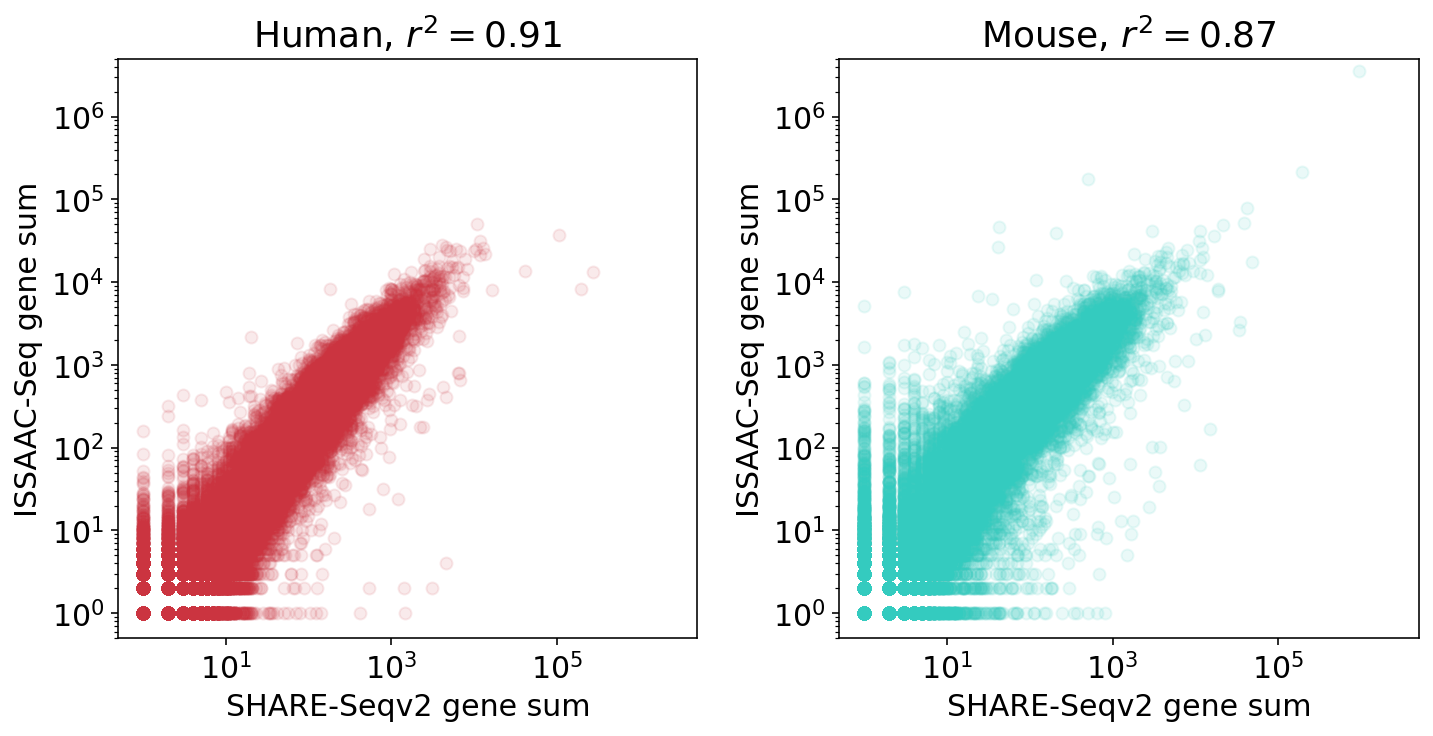

In [44]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = ss_hg.values
y = sa_hg.values

ax.scatter(x,y, color=red, alpha=0.1)

lx, ly = np.log1p(x).reshape(-1,1), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.set(**{
    "xlabel": "SHARE-Seqv2 gene sum",
    "ylabel": "ISSAAC-Seq gene sum",
    "xscale": "log",
    "yscale": "log",
    "title": f"Human, $r^2={r2:,.2f}$",
    "xlim": (0.5, 5e6),
    "ylim": (0.5, 5e6),
})
yex(ax)

ax = axs[1]
x = ss_mm.values
y = sa_mm.values

ax.scatter(x,y, color=blue, alpha=0.1)
lx, ly = np.log1p(x).reshape(-1,1), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.set(**{
    "xlabel": "SHARE-Seqv2 gene sum",
    "ylabel": "ISSAAC-Seq gene sum",
    "xscale": "log",
    "yscale": "log",
    "title": f"Mouse, $r^2={r2:,.2f}$",
    "xlim": (0.5, 5e6),
    "ylim": (0.5, 5e6),
})
yex(ax)
fig.savefig("figures/cmp_shareseq_issaacseq_gene.png", bbox_inches="tight", dpi=300)
fig.show()

In [260]:
ss_human_nnzero = ss.obs["gene:human_counts_nnzero"] + ss.obs["atac:human_counts_nnzero"]
ss_mouse_nnzero = ss.obs["gene:mouse_counts_nnzero"] + ss.obs["atac:mouse_counts_nnzero"]

sa_human_nnzero = sa.obs["gene:human_counts_nnzero"] + sa.obs["atac:human_counts_nnzero"]
sa_mouse_nnzero = sa.obs["gene:mouse_counts_nnzero"] + sa.obs["atac:mouse_counts_nnzero"]

In [261]:
## shareseq
ss_max = 2000

# when filtering for human dudes
ss_human_min = 800

# when filtering for mouse dudes
ss_mouse_min = 2500

## issaacseq
sa_max = 1000

# when filtering for human dudes
sa_human_min = 1000

# when filtering for mouse dudes
sa_mouse_min = 800

In [262]:
ss_human_mask = np.logical_and(
    ss_mouse_nnzero + ss_human_nnzero > ss_human_min, 
    ss_mouse_nnzero < ss_comb_max
)

ss_mouse_mask = np.logical_and(
    ss_mouse_nnzero + ss_human_nnzero > ss_mouse_min, 
    ss_human_nnzero < ss_comb_max
)

In [263]:
ss_mouse_mask.sum(), ss_human_mask.sum()

(376, 1130)

In [264]:
sa_human_mask = np.logical_and(
    sa_mouse_nnzero + sa_human_nnzero > sa_human_min, 
    sa_mouse_nnzero < sa_comb_max
)

sa_mouse_mask = np.logical_and(
    sa_mouse_nnzero + sa_human_nnzero > sa_mouse_min, 
    sa_human_nnzero < sa_comb_max
)

In [265]:
sa_mouse_mask.sum(), sa_human_mask.sum()

(2923, 2087)

In [266]:
fss_mm = ss[ss_mouse_mask][:,genes_mm].copy()
fss_hg = ss[ss_human_mask][:,genes_hg].copy()

fsa_mm = sa[sa_mouse_mask][:,genes_mm].copy()
fsa_hg = sa[sa_human_mask][:,genes_hg].copy()

In [267]:
print(fss_mm.shape, fss_hg.shape, fsa_mm.shape, fsa_hg.shape, sep="\n")

(376, 57010)
(1130, 60664)
(2923, 57010)
(2087, 60664)


In [268]:
print(fss_mm.shape, fss_hg.shape, fsa_mm.shape, fsa_hg.shape, sep="\n")

(376, 57010)
(1130, 60664)
(2923, 57010)
(2087, 60664)


In [269]:
from mx.mx_inspect import mx_inspect_cols

In [270]:
ss_mm_var = mx_inspect_cols(fss_mm.mod["gene"].X.copy(), fss_mm.var.index.values)
ss_hg_var = mx_inspect_cols(fss_hg.mod["gene"].X.copy(), fss_hg.var.index.values)

sa_mm_var = mx_inspect_cols(fsa_mm.mod["gene"].X.copy(), fsa_mm.var.index.values)
sa_hg_var = mx_inspect_cols(fsa_hg.mod["gene"].X.copy(), fsa_hg.var.index.values)

In [271]:
ss_hg_v = ss_hg_var["counts_variance"]
ss_mm_v = ss_mm_var["counts_variance"]
ss_hg_m = ss_hg_var["counts_mean"]
ss_mm_m = ss_mm_var["counts_mean"]

sa_hg_v = sa_hg_var["counts_variance"]
sa_mm_v = sa_mm_var["counts_variance"]
sa_hg_m = sa_hg_var["counts_mean"]
sa_mm_m = sa_mm_var["counts_mean"]

In [272]:
from scipy.optimize import curve_fit

In [273]:
def meanvar(x, alpha):
    return x + alpha*x**2

In [ ]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2,constrained_layout=True)
ax = axs[0,0]
x = ss_hg_m.values
y = ss_hg_v.values

ax.scatter(x,y, color=red, label="Human")

popt, pcov = curve_fit(meanvar, x[x>0], y[x>0])
xx = np.linspace(x[x>0].min(), x[x>0].max(), 5000)
yy = meanvar(xx, popt[0])
ax.plot(xx, yy, color="k", linestyle="--", label=f"α={popt[0]:,.2f}")

ax.set(**{
    "xlabel": "Gene mean",
    "ylabel": "Gene Variance",
    "xscale": "log",
    "yscale": "log",
    "title": "SHARE-seqV2",
    "xlim": (1e-4, 4e4),
    "ylim": (1e-4, 4e4)
})
ax.legend()
yex(ax, True)

ax = axs[0,1]
x = ss_mm_m.values
y = ss_mm_v.values

ax.scatter(x,y, color=blue, label="Mouse")

popt, pcov = curve_fit(meanvar, x[x>0], y[x>0])
xx = np.linspace(x[x>0].min(), x[x>0].max(), 5000)
yy = meanvar(xx, popt[0])
ax.plot(xx, yy, color="k", linestyle="--", label=f"α={popt[0]:,.2f}")

ax.set(**{
    "xlabel": "Gene mean",
    "ylabel": "Gene Variance",
    "xscale": "log",
    "yscale": "log",
    "title": "SHARE-seqV2",
    "xlim": (1e-4, 4e4),
    "ylim": (1e-4, 4e4)
})
ax.legend()
yex(ax, True)

ax = axs[1,0]
x = sa_hg_m.values
y = sa_hg_v.values

ax.scatter(x,y, color=red, label="Human")

popt, pcov = curve_fit(meanvar, x[x>0], y[x>0])
xx = np.linspace(x[x>0].min(), x[x>0].max(), 5000)
yy = meanvar(xx, popt[0])
ax.plot(xx, yy, color="k", linestyle="--", label=f"α={popt[0]:,.2f}")

ax.set(**{
    "xlabel": "Gene mean",
    "ylabel": "Gene Variance",
    "xscale": "log",
    "yscale": "log",
    "title": "ISSAAC-seq",
    "xlim": (1e-4, 4e4),
    "ylim": (1e-4, 4e4)
})
ax.legend()
yex(ax, True)

ax = axs[1,1]
x = sa_mm_m.values
y = sa_mm_v.values

ax.scatter(x,y, color=blue, label="Mouse")

popt, pcov = curve_fit(meanvar, x[x>0], y[x>0])
xx = np.linspace(x[x>0].min(), x[x>0].max(), 5000)
yy = meanvar(xx, popt[0])
ax.plot(xx, yy, color="k", linestyle="--", label=f"α={popt[0]:,.2f}")

ax.set(**{
    "xlabel": "Gene mean",
    "ylabel": "Gene Variance",
    "xscale": "log",
    "yscale": "log",
    "title": "ISSAAC-seq",
    "xlim": (1e-4, 4e4),
    "ylim": (1e-4, 4e4)
})
ax.legend()
yex(ax, True)
fig.show()

In [274]:
data = [{"label": "Human", "assay": "SHARE-seqV2", "x": ss_hg_m.values, "y": ss_hg_v.values},
        {"label": "Mouse", "assay": "SHARE-seqV2", "x": ss_mm_m.values, "y": ss_mm_v.values},
        {"label": "Human", "assay": "ISSAAC-seq", "x":  sa_hg_m.values, "y": sa_hg_v.values},
        {"label": "Mouse", "assay": "ISSAAC-seq", "x":  sa_mm_m.values, "y": sa_mm_v.values}]

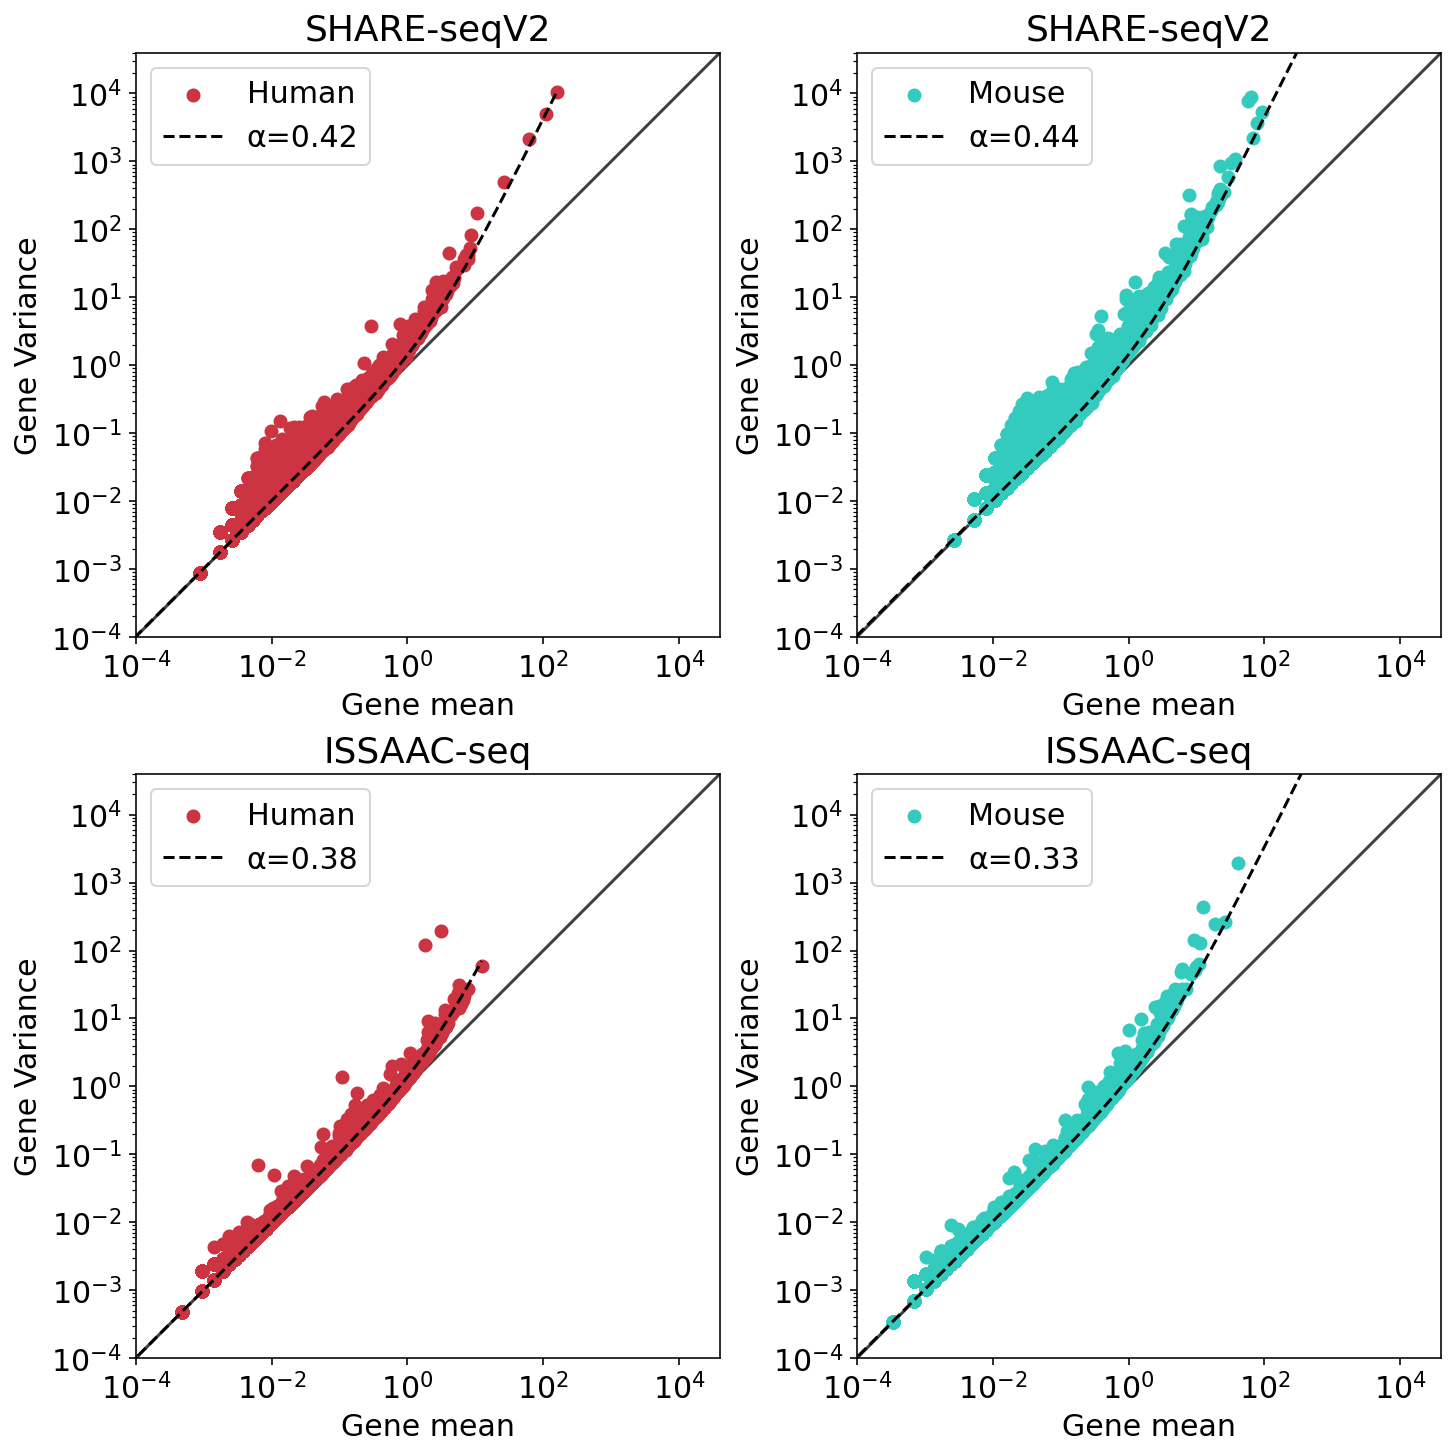

In [280]:
fig, axs = plt.subplots(figsize=(10,10), nrows=2, ncols=2,constrained_layout=True)

for ax, d in zip(fig.axes, data):
    x = d["x"]
    y = d["y"]
    label = d["label"]
    assay = d["assay"]
    color = {"Human": red, "Mouse":blue}.get(label)
    ax.scatter(x,y, label=label, color=color)

    popt, pcov = curve_fit(meanvar, x, y)
    xx = np.linspace(x.min(), x.max(), 5000)
    yy = meanvar(xx, popt[0])
    ax.plot(xx, yy, color="k", linestyle="--", label=f"α={popt[0]:,.2f}")

    ax.set(**{
        "xlabel": "Gene mean",
        "ylabel": "Gene Variance",
        "xscale": "log",
        "yscale": "log",
        "title": assay,
        "xlim": (1e-4, 4e4),
        "ylim": (1e-4, 4e4)
    })

    yex(ax, True)
    ax.legend()
fig.savefig("figures/mean_var_share_issaac.png", bbox_inches="tight", dpi=300)
fig.show()

In [ ]:
# departure from poisson, fit graph

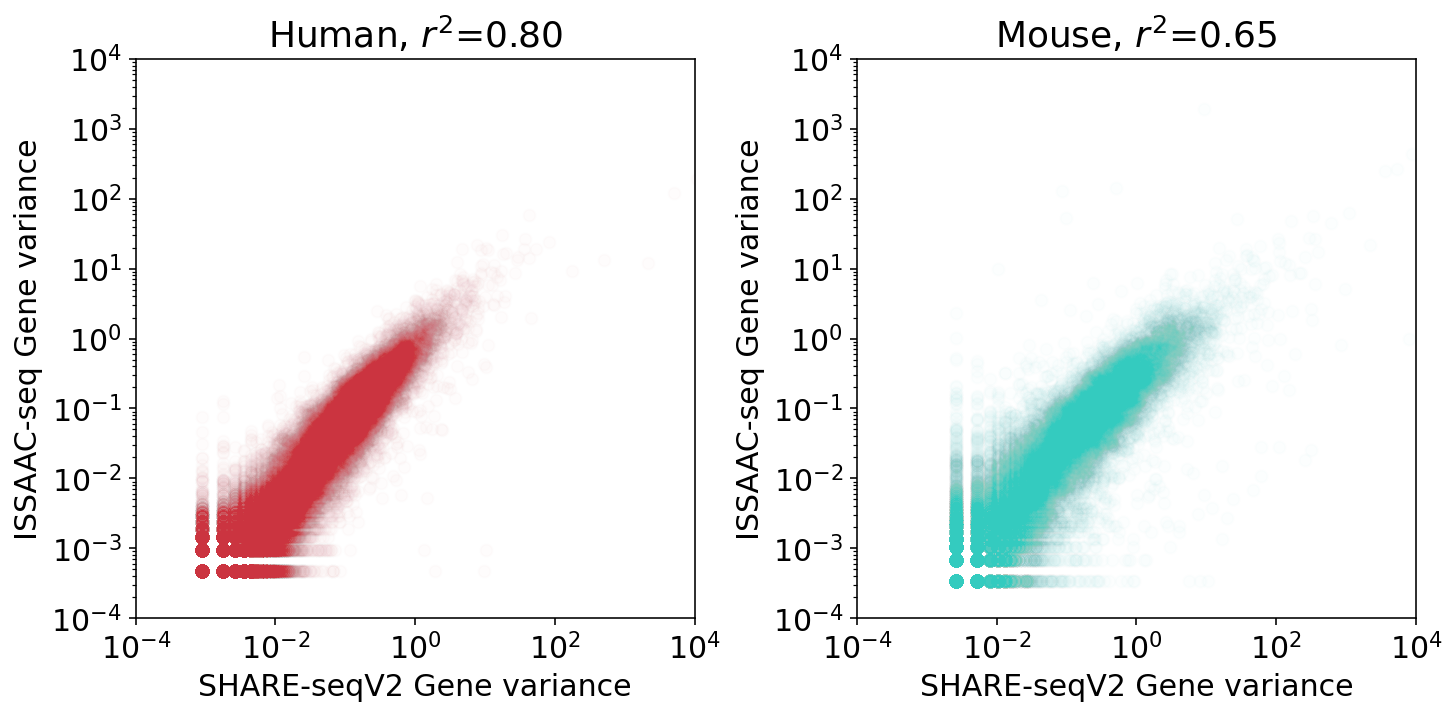

In [279]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
x = ss_hg_v.values
y = sa_hg_v.values

ax.scatter(x, y, color=red, alpha=0.01)

lx, ly = np.log1p(x).reshape(-1,1), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.set(**{
    "xscale": "log", 
    "yscale": "log", 
    "xlabel": "SHARE-seqV2 Gene variance", 
    "ylabel": "ISSAAC-seq Gene variance", 
    "title": f"Human, $r^2$={r2:,.2f}",
    "xlim": (1e-4, 1e4),
    "ylim": (1e-4, 1e4)
})
yex(ax)

ax = axs[1]
x = ss_mm_v.values
y = sa_mm_v.values

ax.scatter(x, y, color=blue, alpha=0.01)

lx, ly = np.log1p(x).reshape(-1,1), np.log1p(y)
reg = LinearRegression().fit(lx, ly)
r2 = reg.score(lx, ly)

ax.set(**{
    "xscale": "log", 
    "yscale": "log", 
    "xlabel": "SHARE-seqV2 Gene variance", 
    "ylabel": "ISSAAC-seq Gene variance", 
    "title": f"Mouse, $r^2$={r2:,.2f}",
    "xlim": (1e-4, 1e4),
    "ylim": (1e-4, 1e4)
})
yex(ax)
fig.savefig("figures/filtered_gene_var_cmp.png", bbox_inches="tight", dpi=300)
fig.show()